## Assessing allelic bias in RADseq data

Can we identify 'bad' loci by looking at allelic bias in heterozygotes?

Within a *heterozygous* individual we can assess allelic bias at a specific locus with a binomial test.  The null hypothesis is that each allelic sequence is equally likely. The p value represents the likelihood of a bias at least as big as observed under the null. Notice this is a two-tailed test.

In [1]:
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import numpy as np

In [2]:
%matplotlib inline

## Example bionimial test

In [3]:
coverage_allele_a = 10
coverage_allele_b = 30

p_value = scipy.stats.binom_test((coverage_allele_a,coverage_allele_b))
print(p_value)

0.00222143377323


Caveat: due to PCR duplicates the reads may not be **truly** independent, hopefully this effect is not allele-specific.

### Assessing one locus across multiple individuals

By observing allele bias at a target locus across multiple individuals we can try to see if there is a **consistent** bias.  

This raises the question of how to combine data from many individuals, I see two distinct options:
   1. weight each **allele observation** equally, essentially ignoring the indidviual that they appear in.  This implicitly assumes that any process generating bias operates somewhat cosistently across individuals.
   2. weight each **individual** equally, this accounts for the difference in coverage across individuals, ignoring the fact that individuals with difference coverages provide more information on allelic bias.
   
   OR 
   3. some combination the two.

#### In case 1. we can simply add up all the observations of the 'a' alelle and all observations of the 'b' allele and run the same binomial test.

In [4]:
coverage_allele_a_accross_individuals = (25,13,2,3,7,17,9,29,51,2,4,29,14)
coverage_allele_a = sum(coverage_allele_a_accross_individuals)
print('coverage_allele_a: {}'.format(coverage_allele_a))

coverage_allele_b_accross_individuals = (28,23,22,1,17,14,19,5,27,12,8,21,19)
coverage_allele_b = sum(coverage_allele_b_accross_individuals)
print('coverage_allele_a: {}'.format(coverage_allele_b))

p_value = scipy.stats.binom_test((coverage_allele_a,coverage_allele_b))
print(p_value)

coverage_allele_a: 205
coverage_allele_a: 216
0.626048377669


#### In case 2. we keep each individual separate.

In [5]:
ab = zip(coverage_allele_a_accross_individuals, coverage_allele_b_accross_individuals)
p_vals = [scipy.stats.binom_test(xx) for xx in ab]
p_vals

[0.78384630220949836,
 0.13249816396273675,
 3.5881996154785156e-05,
 0.625,
 0.063914656639099121,
 0.72010013181716115,
 0.087158553302288042,
 3.8558151572942747e-05,
 0.0087717144570601362,
 0.012939453124999998,
 0.38769531250000011,
 0.32223632035754712,
 0.4868502416647969]

combine the p values into one measure

Fisher's method

In [6]:
fisher_statistic, fisher_pval = scipy.stats.combine_pvalues(p_vals, method = 'fisher')
fisher_statistic, fisher_pval

(81.070899768715066, 1.4321730977438808e-07)

Stouffer's method.



In [7]:
stouffer_statistic, stouffer_pval = scipy.stats.combine_pvalues(p_vals, method = 'stouffer', weights = None) # can be weighted
stouffer_statistic, stouffer_pval

(4.3308924674047935, 7.4253098511083297e-06)

In this method you can weight the individuals.

In [8]:
my_weights = [np.sqrt(sum([a,b])) for a,b in ab]
stouffer_statistic, stouffer_pval = scipy.stats.combine_pvalues(p_vals, method = 'stouffer', weights = my_weights) # can be weighted
stouffer_statistic, stouffer_pval

(4.2883981531672024, 8.9983142308648029e-06)

### Create file of allelic depths

In [11]:
def write_allele_bias_file2(vcf_file, out_file):
    with open(vcf_file) as INFILE:
        with open(out_file, 'w') as OUTFILE:
            for line in INFILE:
                if line.startswith('##'):
                    print 'skipped!'
                    pass
                elif line.startswith('#CHROM'):
                    header = line.strip().strip('#').split('\t')
                    inds = header[9:]
                    #print(inds)
                else:
                    tabs = line.split('\t')
                    contig = tabs[0]
                    pos = tabs[1]
                    genotypes = tabs[9:]
                    depth_a_of_ind = dict()
                    depth_b_of_ind = dict()
                    for gen_idx, gen in enumerate(genotypes):
                        if gen.split(':')[0] in ['1/0', '0/1']: # if het
                            depth_a_of_ind[inds[gen_idx]] = int(gen.split(':')[2].split(',')[0])
                            depth_b_of_ind[inds[gen_idx]] = int(gen.split(':')[2].split(',')[1])
                    sum_a = sum(depth_a_of_ind.values())
                    sum_b = sum(depth_b_of_ind.values())
                    if sum_a+sum_b > 0:
                        OUTFILE.write('{}\t{}\t{}\t{}\t{}\n'.format(contig, pos, sum_a, sum_b, np.float(sum_a)/(sum_a+sum_b)))

In [12]:
write_allele_bias_file2(vcf_file='/home/ipseg/Desktop/waples/temp/batch_10_singleSNP.vcf', out_file = '/home/ipseg/Desktop/waples/temp/batch_10_singleSNP.depths')

skipped!
skipped!
skipped!
skipped!
skipped!
skipped!
skipped!
skipped!
skipped!


In [13]:
depths = pd.read_csv('/home/ipseg/Desktop/waples/temp/batch_10_singleSNP.depths', sep = '\t', header = None)
depths.columns = ['contgis', 'pos', 'depth_a' , 'depth_b', 'ratio']
depths['total_depth'] = depths['depth_a'] + depths['depth_b']
depths.head()

,contgis,pos,depth_a,depth_b,ratio,total_depth
0,un,161,177,177,0.500000,354
1,un,207,91,81,0.529070,172
2,un,353,5138,7968,0.392034,13106
3,un,451,274,285,0.490161,559
4,un,565,930,943,0.496530,1873


#### calculated the expected std deviation, based on the binomial distribution

In [14]:
depths['std'] = scipy.stats.binom(n = depths['total_depth'], p = .5).std()
depths.head()

,contgis,pos,depth_a,depth_b,ratio,total_depth,std
0,un,161,177,177,0.500000,354,9.407444
1,un,207,91,81,0.529070,172,6.557439
2,un,353,5138,7968,0.392034,13106,57.240720
3,un,451,274,285,0.490161,559,11.821590
4,un,565,930,943,0.496530,1873,21.639085


#### Z-score based on that std deviation

In [15]:
depths['z'] = -(depths['total_depth']/2. - depths['depth_a'])/ depths['std']
depths.head()

,contgis,pos,depth_a,depth_b,ratio,total_depth,std,z
0,un,161,177,177,0.500000,354,9.407444,-0.000000
1,un,207,91,81,0.529070,172,6.557439,0.762493
2,un,353,5138,7968,0.392034,13106,57.240720,-24.720164
3,un,451,274,285,0.490161,559,11.821590,-0.465250
4,un,565,930,943,0.496530,1873,21.639085,-0.300382


Fraction of 'a' alleles

In [16]:
sum_a = sum(depths['depth_a'])
sum_b = sum(depths['depth_b'])
frac_a = np.float(sum_a)/(sum_a + sum_b)
print sum_a, sum_b, frac_a

27601783 24616071 0.528588995634


Highly significant!

In [17]:
p_value = scipy.stats.binom_test((sum_a, sum_b))
print(p_value)

2.32210853545e-322


In [27]:
from IPython.core.pylabtools import figsize
figsize(10,10)

## Remove some high-coverage loci

In [ ]:
depths = depths[depths['total_depth'] < 100000]

## TODO: Merge/compare with filtered data

Absolute allele count difference

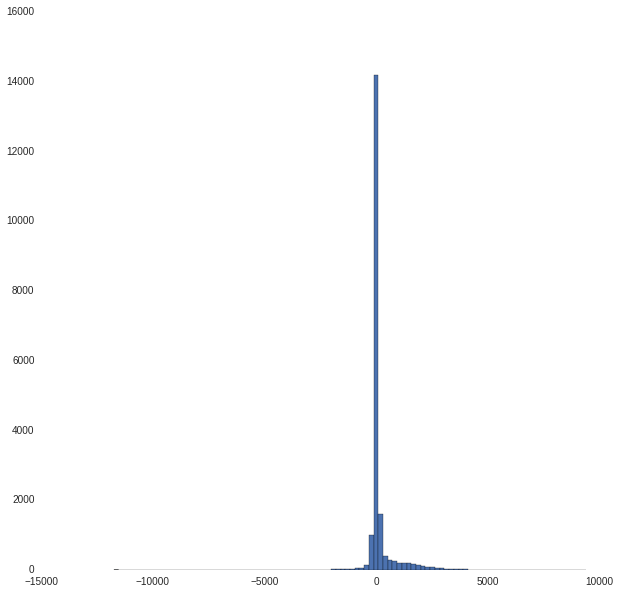

In [28]:
plt.hist(depths['depth_a']-depths['depth_b'], bins = 100)
plt.show()

Allelelic ratios

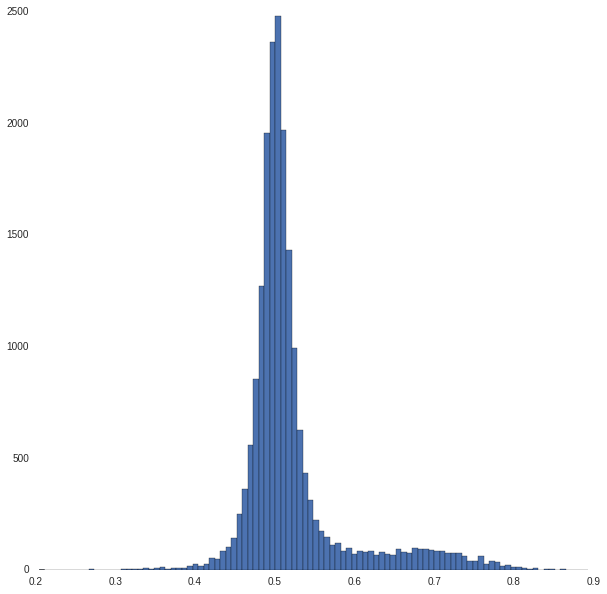

In [29]:
plt.hist(depths['ratio'], bins = 100)
plt.show()

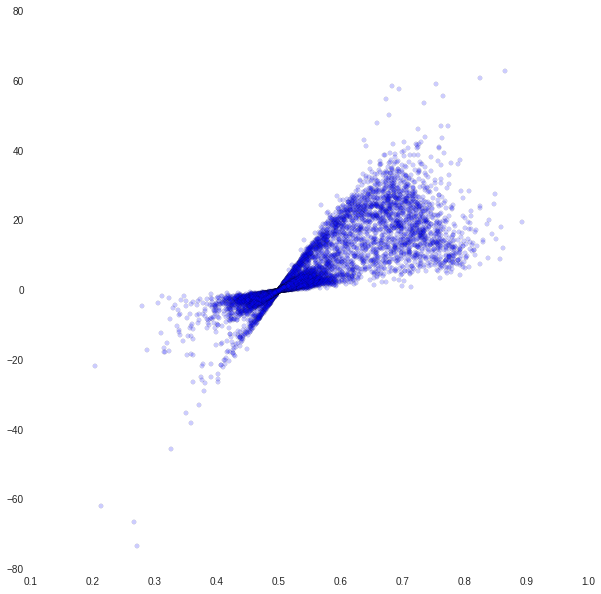

In [30]:
plt.scatter(depths['ratio'], depths['z'], alpha = .2)
plt.show()

histogram of z-scores

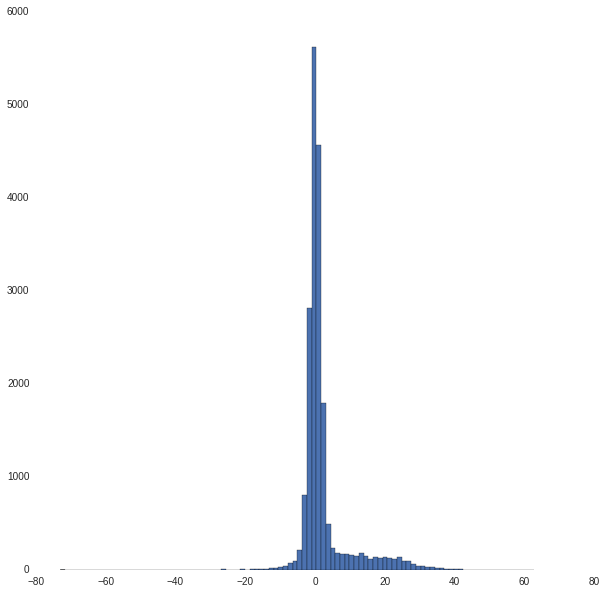

In [31]:
plt.hist(depths['z'], bins = 100)
plt.show()

Higher depths leads to somewhat more bias

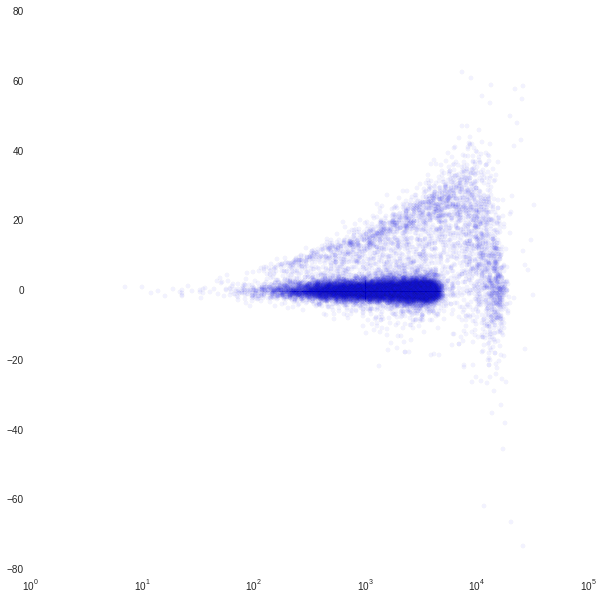

In [48]:
plt.scatter(depths['total_depth'], depths['z'], alpha = .05)
plt.xscale('log')
plt.show()

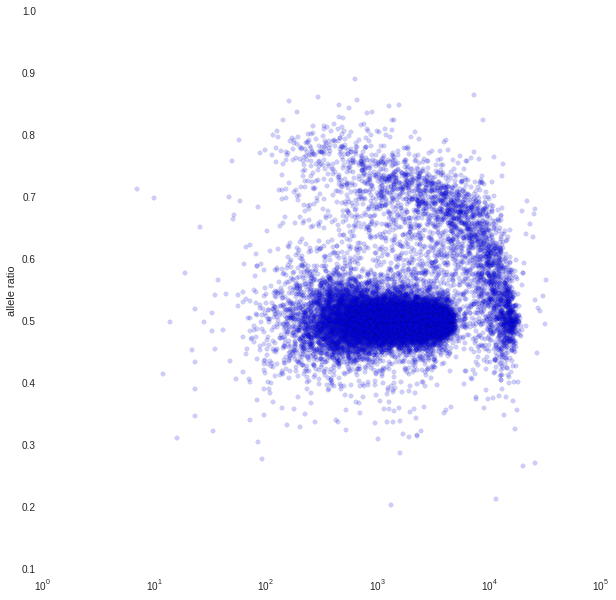

In [43]:
plt.scatter(depths['total_depth'], depths['ratio'], alpha = .2)
plt.ylabel('allele ratio')
plt.xscale('log')
plt.show()

No clear pattern of depth by position, maybe a slight trend down near the end of the reads.

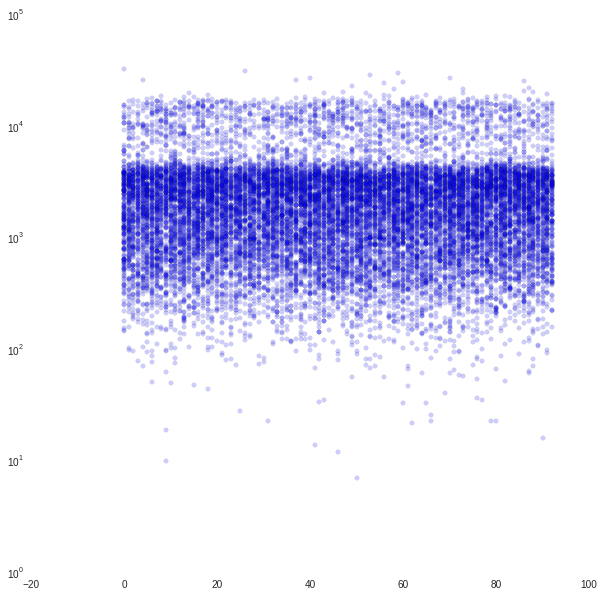

In [33]:
plt.scatter(depths['pos']%93, depths['total_depth'], alpha = .2)
plt.yscale('log')
plt.show()

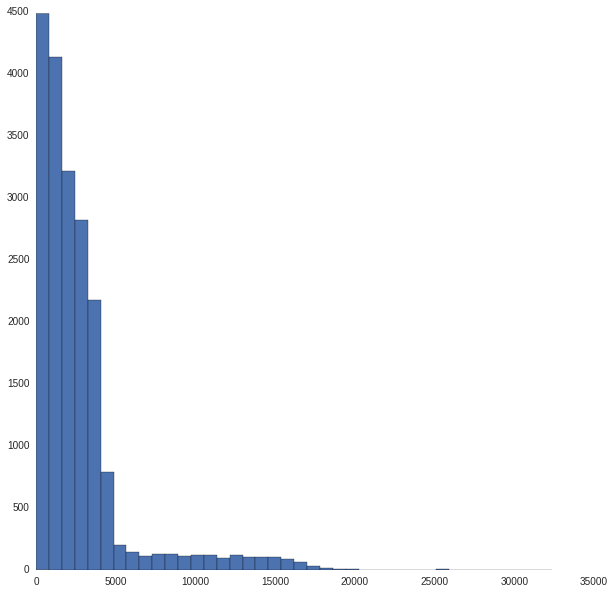

In [36]:
plt.hist(depths['total_depth'], bins = 40)
plt.show()

How is the z-score related to the allelic ratio?

Bias by position

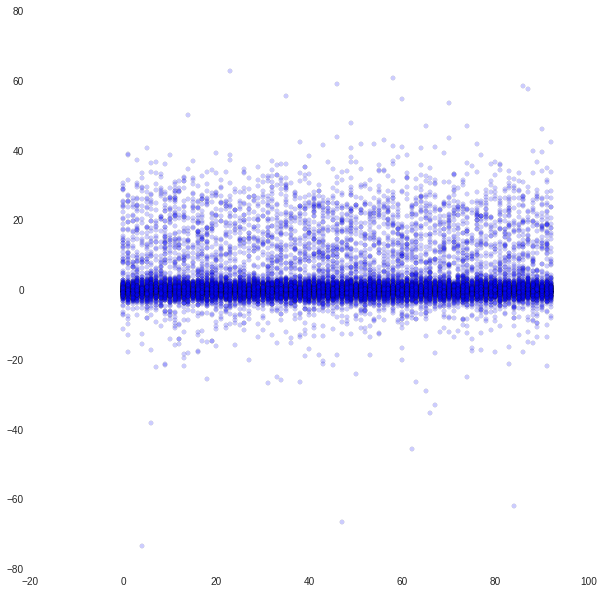

In [42]:
plt.scatter(depths['pos']%93, depths['z'], alpha = .2)
plt.show()

Relation to depth

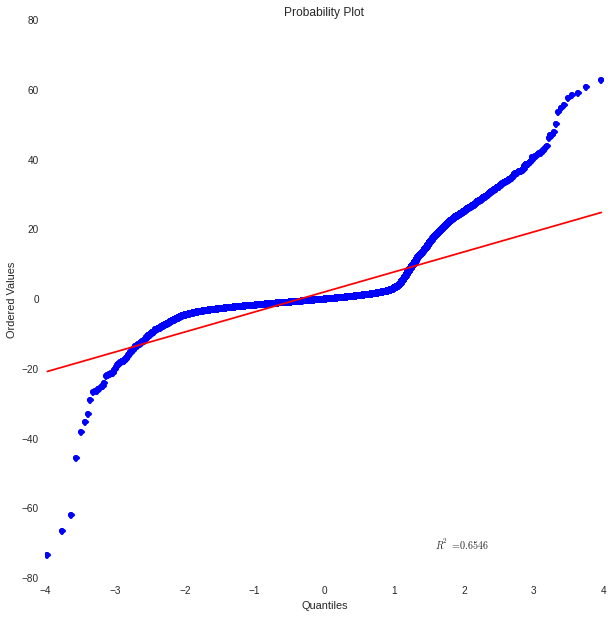

In [44]:
scipy.stats.probplot(depths['z'], dist="norm", plot=plt)
plt.show()

(-5, 5)

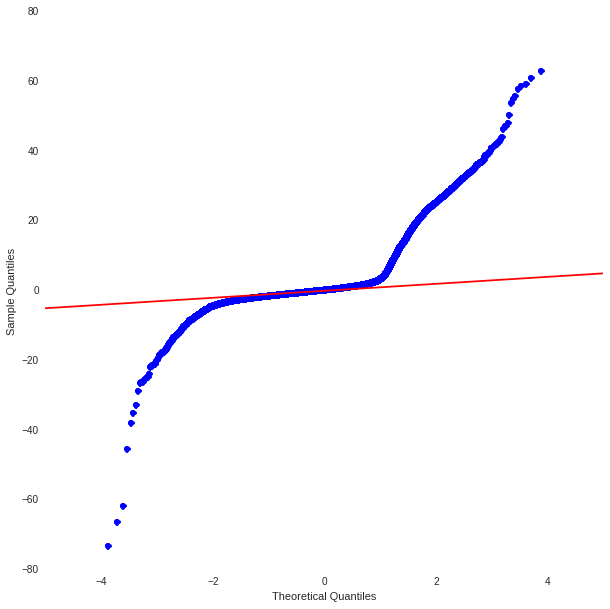

In [45]:
qq = statsmodels.graphics.gofplots.qqplot(depths['z'], line = '45')
plt.xlim(-5,5)

In [46]:
def write_allele_bias_file_by_ind(vcf_file, out_file):
    with open(vcf_file) as INFILE:
        with open(out_file, 'w') as OUTFILE:
            for line in INFILE:
                if line.startswith('##'):
                    print 'skipped!'
                    pass
                elif line.startswith('#CHROM'):
                    header = line.strip().strip('#').split('\t')
                    inds = header[9:]
                    #print(inds)
                else:
                    tabs = line.split('\t')
                    contig = tabs[0]
                    pos = tabs[1]
                    genotypes = tabs[9:]
                    depth_a_of_ind = dict()
                    depth_b_of_ind = dict()
                    for gen_idx, gen in enumerate(genotypes):
                        if gen.split(':')[0] in ['1/0', '0/1']: # if het
                            depth_a = int(gen.split(':')[2].split(',')[0])
                            depth_b = int(gen.split(':')[2].split(',')[1])
                            std = scipy.stats.binom(n = depth_a + depth_b, p = .5).std()
                            z = ((depth_a + depth_b)/2. - depth_a)/ -std          
                            OUTFILE.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(
                                    contig, pos, inds[gen_idx], depth_a, depth_b, std, z))

In [47]:
write_allele_bias_file_by_ind(vcf_file='/home/ipseg/Desktop/waples/temp/batch_10_singleSNP.vcf', out_file = '/home/ipseg/Desktop/waples/temp/batch_10_singleSNP.depths_by_ind')

skipped!
skipped!
skipped!
skipped!
skipped!
skipped!
skipped!
skipped!
skipped!


# END WORK

## Logistic regression 
see http://blog.yhathq.com/posts/logistic-regression-and-python.html

# This file is HUGE

In [206]:
write_allele_bias_file(vcf_file='/home/ipseg/Desktop/waples/temp/batch_4.vcf', out_file = '/home/ipseg/Desktop/waples/temp/batch_4.AB')

skipped!
skipped!
skipped!
skipped!
skipped!
skipped!
skipped!
skipped!
skipped!


In [208]:
df = pd.read_csv('/home/ipseg/Desktop/waples/temp/batch_4.AB', sep = '\t', header = None)

,0,1,2,3
0,c1000,75,CMSTILL10_0055,0
1,c1000,75,CMSTILL10_0055,0
2,c1000,75,CMSTILL10_0055,0
3,c1000,75,CMSTILL10_0055,0
4,c1000,75,CMSTILL10_0055,0


In [211]:
df.columns = ['contig', 'pos', 'ind', 'allele']
print len(df)
df.head()

120116103


,contig,pos,ind,allele
0,c1000,75,CMSTILL10_0055,0
1,c1000,75,CMSTILL10_0055,0
2,c1000,75,CMSTILL10_0055,0
3,c1000,75,CMSTILL10_0055,0
4,c1000,75,CMSTILL10_0055,0


In [214]:
df_sub = df[1:5000000]

In [217]:
df_sub = df_sub[1:1000000]

In [218]:
del df

NameError: name 'df' is not defined

In [224]:
dum_df = pd.get_dummies(df_sub['contig'])
dum_df['intercept'] = 1.0
dum_df.head()

,c1000,c10000,c10001,c10003,c10012,c10019,c1002,c10020,c10022,c10027,...,c10442,c10451,c10454,c10455,c10458,c10459,c1046,c10463,c10467,intercept
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [225]:
train_cols = dum_df.columns
train_cols

Index([u'c1000', u'c10000', u'c10001', u'c10003', u'c10012', u'c10019',
       u'c1002', u'c10020', u'c10022', u'c10027', 
       ...
       u'c10442', u'c10451', u'c10454', u'c10455', u'c10458', u'c10459',
       u'c1046', u'c10463', u'c10467', u'intercept'],
      dtype='object', length=128)

In [226]:
logit = sm.Logit(df_sub['allele'], dum_df[train_cols])

In [228]:
logit.information()

TypeError: information() takes exactly 2 arguments (1 given)

In [222]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.687926
         Iterations 5


In [92]:
#result.summary()

z-score vs allelic ratio 

bp postion

qq plots

In [205]:
def write_allele_bias_file(vcf_file, out_file):
    with open(vcf_file) as INFILE:
        with open(out_file, 'w') as OUTFILE:
            for line in INFILE:
                if line.startswith('##'):
                    print 'skipped!'
                    pass
                elif line.startswith('#CHROM'):
                    header = line.strip().strip('#').split('\t')
                    inds = header[9:]
                    #print(inds)
                else:
                    tabs = line.split('\t')
                    contig = tabs[0]
                    pos = tabs[1]
                    genotypes = tabs[9:]
                    depth_a_of_ind = dict()
                    depth_b_of_ind = dict()
                    for gen_idx, gen in enumerate(genotypes):
                        if gen.split(':')[0] in ['1/0', '0/1']: # if het
                            depth_a_of_ind[inds[gen_idx]] = int(gen.split(':')[2].split(',')[0])
                            depth_b_of_ind[inds[gen_idx]] = int(gen.split(':')[2].split(',')[1])
                    for ind, depth_a in depth_a_of_ind.items():
                        for xx in range(depth_a):
                            OUTFILE.write('{}\t{}\t{}\t{}\n'.format(contig, pos, ind, '0'))
                    for ind, depth_b in depth_b_of_ind.items():
                        for xx in range(depth_b):
                            OUTFILE.write('{}\t{}\t{}\t{}\n'.format(contig, pos, ind, '1'))

In [38]:
depths['p_val'] = 1 - scipy.special.ndtr(np.abs(depths['z']))
depths.head()

,contgis,pos,depth_a,depth_b,ratio,total_depth,std,z,p_val
0,c1000,75,4191,5493,0.432776,9684,49.203658,-13.230724,0.000000
1,c1000,93,3928,2422,0.618583,6350,39.843444,18.898969,0.000000
4,c10001,81,1069,1053,0.503770,2122,23.032586,0.347334,0.364170
5,c10001,92,552,690,0.444444,1242,17.621010,-3.915780,0.000045
6,c10003,79,624,1223,0.337845,1847,21.488369,-13.937773,0.000000


In [ ]:
ob = -np.log10(sorted(depths['p_val']))
ex = -np.log10(np.linspace(0,1.0,len(depths)))

In [12]:
rv = scipy.stats.binom(n = 1000, p = .5)
rv.interval(.50)
rv.std()

15.811388300841896

In [250]:
plt.hist(scipy.stats.mstats.zscore(depths['ratio']))
plt.show()

In [ ]:
plt.hist(depths['ratio'], bins = 100)
plt.show()

In [159]:
import vcf
def write_allele_bias_file(vcf_file, out_file):
    vcf_reader = vcf.Reader(open(vcf_file, 'r'))
    record = vcf_reader.next()
    print record
        #record.get_hets()
    with open(out_file, 'w') as OUTFILE:
        pass
            

In [160]:
write_allele_bias_file(vcf_file='/home/ipseg/Desktop/waples/temp/batch_4.vcf', out_file = '/home/ipseg/Desktop/waples/temp/batch_4.AB' )

ValueError: invalid literal for float(): 4,1

In [135]:
df = pd.read_csv("/home/ipseg/Desktop/waples/temp/allele_bias.txt", sep = '\t')
df.head()

,locus,ind,allele
0,l1,i1,0
1,l1,i1,0
2,l1,i1,0
3,l1,i1,0
4,l1,i1,1


In [138]:
dum_df = pd.get_dummies(df)
dum_df.head()

,allele,locus_l1,locus_l2,ind_i1,ind_i2,ind_i3,ind_i4,ind_i5
0,0,1,0,1,0,0,0,0
1,0,1,0,1,0,0,0,0
2,0,1,0,1,0,0,0,0
3,0,1,0,1,0,0,0,0
4,1,1,0,1,0,0,0,0


In [145]:
train_cols = dum_df.columns[1:3]
train_cols

Index([u'locus_l1', u'locus_l2'], dtype='object')

In [146]:
logit = sm.Logit(dum_df['allele'], dum_df[train_cols])

In [147]:
# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.676627
         Iterations 4


In [148]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                 allele   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Jun 2015   Pseudo R-squ.:                 0.01397
Time:                        16:23:21   Log-Likelihood:                -69.016
converged:                       True   LL-Null:                       -69.993
                                        LLR p-value:                    0.1620
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
locus_l1      -0.5213      0.290     -1.800      0.072        -1.089     0.046
locus_l2       0.0392      0.280      0.140      0.889        -0.510     0.588


In [149]:
result.conf_int()

,0,1
locus_l1,-1.088948,0.046354
locus_l2,-0.509785,0.588226


In [150]:
result.params

locus_l1   -0.521297
locus_l2    0.039221
dtype: float64

In [120]:
df = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")
df.columns = ["admit", "gre", "gpa", "prestige"]
df.head()

,admit,gre,gpa,prestige
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [121]:
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
dummy_ranks.head()

,prestige_1,prestige_2,prestige_3,prestige_4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [123]:
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
data['intercept'] = 1.0
data.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
0,0,380,3.61,0,1,0,1
1,1,660,3.67,0,1,0,1
2,1,800,4.00,0,0,0,1
3,1,640,3.19,0,0,1,1
4,0,520,2.93,0,0,1,1


In [124]:
train_cols = data.columns[1:]
 
logit = sm.Logit(data['admit'], data[train_cols])
 
# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6


In [125]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Tue, 16 Jun 2015   Pseudo R-squ.:                 0.08292
Time:                        16:06:29   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 7.578e-08
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0023      0.001      2.070      0.038         0.000     0.004
gpa            0.8040      0.332      2.423      0.015         0.154     1.454
prestige_2    -0.6754      0.316     -2.134      0.0

In [113]:
[scipy.stats.binom.cdf(a, a+b, 0.5) for a,b in ab]
[scipy.stats.binom_test(xx) for xx in ab]

[0.78384630220949836,
 0.13249816396273675,
 3.5881996154785156e-05,
 0.625,
 0.063914656639099121,
 0.72010013181716115,
 0.087158553302288042,
 3.8558151572942747e-05,
 0.0087717144570601362,
 0.012939453124999998,
 0.38769531250000011,
 0.32223632035754712,
 0.4868502416647969]

In [ ]:
getting at a 

In [52]:
[scipy.stats.binom.cdf(a, a+b, 0.5) for a,b in ab]

[0.21217811107635506,
 0.066249081981368377,
 1.7940998077392578e-05,
 1.0,
 0.031957328319549561,
 0.76343517005443584,
 0.043579276651144021,
 0.99999691755510867,
 0.99783255955824635,
 0.0064697265624999991,
 0.63671874999999989,
 0.89868062446772967,
 0.24342512083239845]

In [47]:
scipy.stats.binom.pmf([0,1,2], 2, 0.5)

array([ 0.25,  0.5 ,  0.25])

In [42]:
import numpy as np

scipy.stats.binom(n = 10, p = .50).isf(x=np.arange(0,1, .01))



TypeError: isf() got an unexpected keyword argument 'x'

In [ ]:
def Stouffer_test(p, w=None):
    if w:
        pass
    else:
        w <- [1.0/len(p)] * len(p)
    print(w)
        
    if len(w) != len(p)
      break "Length of p and w must equal!"
  
    Zi <- qnorm(1-p) 
    Z  <- sum(w*Zi)/sqrt(sum(w^2))
    p.val <- 1-pnorm(Z)
    return(c(Z = Z, p.value = p.val))
}

In [5]:
#### In case 2 we can simply add up all the observation of the 'A' alelle and all observations of the 'B' allele and run a binomial test.

NameError: name 'seq' is not defined